In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

C:\Users\jiaha\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0'

class MaskDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)),
            nn.GELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2)),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2)),
            nn.GELU(),
            nn.ConvTranspose2d(32, 20, kernel_size=(2, 2), stride=(2, 2))
        )

    def forward(self, img_embed):
        """ img_embed: (B, 256, 64, 64)
            @returns (B, C, 1024, 1024) logits
        """
        return self.layers(img_embed)

model = MaskDecoder()
model = model.to(device)

In [3]:
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

class PeoplePosesDataset(Dataset):
    def __init__(self, device, mode="train", img_size=1024):
        assert mode in ("train", "val")
        self.mode = mode
        self.root = "../../datasets/people_poses"
        self.image_dir = os.path.join(self.root, f"{self.mode}_images")
        self.mask_dir = os.path.join(self.root, f"{self.mode}_segmentations")
        self.embed_dir = os.path.join(self.root, f"{self.mode}_embeds")
        with open(os.path.join(self.root, f"{self.mode}_id.txt"), 'r') as lf:
            self.data_list = [ s.strip() for s in lf.readlines() ]
        self.img_size = img_size
        self.device = device

    def __len__(self):
        return len(self.data_list)

    def preprocess(self, x):
        # TODO(jiahang): clean up this dependency issue
        x = (x - model.sam.pixel_mean) / model.sam.pixel_std

        h, w = x.shape[-2:]
        padh = self.img_size - h
        padw = self.img_size - w
        x = F.pad(x, (0, padw, 0, padh))
        return x
    
    def __getitem__(self, index):
        data = np.load(os.path.join(self.embed_dir, self.data_list[index] + ".npz"))
        return data['embed'], data['label']

In [5]:
from tqdm import tqdm

device = 'cuda:0'
dataset = PeoplePosesDataset(device)
dataloader = DataLoader(dataset, batch_size=12, shuffle=True)
                        # num_workers=4, prefetch_factor=8)
                        # collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

def loss_fn(logits, labels):
    """ logits/labels: (B, C, 1024, 1024) """
    return F.cross_entropy(logits, labels, ignore_index=-1, reduction='mean')

def train_one_epoch(epoch_index):
    for data in (pbar := tqdm(dataloader)):
        embeds, labels = data
        embeds = embeds.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(embeds)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'loss: {loss}')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(20):
    print('EPOCH {}:'.format(epoch))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    train_one_epoch(epoch)

    model_path = 'v1/model_{}.pth'.format(epoch)
    torch.save(model.state_dict(), model_path)

EPOCH 0:


loss: 0.548587441444397: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:58<00:00,  1.46it/s]


EPOCH 1:


loss: 0.6137377619743347: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:19<00:00,  1.49it/s]


EPOCH 2:


loss: 0.8635512590408325: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:44<00:00,  1.47it/s]


EPOCH 3:


loss: 0.7659903764724731: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:24<00:00,  1.49it/s]


EPOCH 4:


loss: 0.6935817003250122: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:15<00:00,  1.50it/s]


EPOCH 5:


loss: 1.1908248662948608: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:09<00:00,  1.50it/s]


EPOCH 6:


loss: 0.7706693410873413: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:41<00:00,  1.47it/s]


EPOCH 7:


loss: 0.6528021097183228: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:50<00:00,  1.47it/s]


EPOCH 8:


loss: 0.44693735241889954: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:31<00:00,  1.48it/s]


EPOCH 9:


loss: 0.838813304901123: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:31<00:00,  1.48it/s]


EPOCH 10:


loss: 0.7010893225669861: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:37<00:00,  1.48it/s]


EPOCH 11:


loss: 0.6149864196777344: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:22<00:00,  1.49it/s]


EPOCH 12:


loss: 0.5772626399993896: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [30:03<00:00,  1.41it/s]


EPOCH 13:


loss: 0.5980163216590881: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [30:20<00:00,  1.39it/s]


EPOCH 14:


loss: 0.702826738357544: 100%|████████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [30:31<00:00,  1.39it/s]


EPOCH 15:


loss: 0.7933297157287598: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:26<00:00,  1.49it/s]


EPOCH 16:


loss: 0.5534000396728516: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:22<00:00,  1.49it/s]


EPOCH 17:


loss: 0.6412922143936157: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:23<00:00,  1.49it/s]


EPOCH 18:


loss: 0.35156846046447754: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [28:34<00:00,  1.48it/s]


EPOCH 19:


loss: 1.0349034070968628: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2539/2539 [32:58<00:00,  1.28it/s]


In [7]:
val_dataset = PeoplePosesDataset(device, mode="val")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [13]:
x, y = val_dataset[0]
x.shape, y.shape

((256, 64, 64), (1024, 1024))

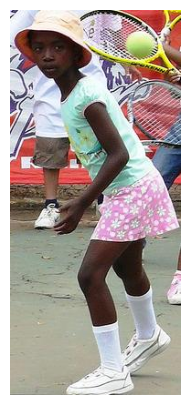

In [14]:
image = cv2.imread(os.path.join(val_dataset.image_dir, val_dataset.data_list[0] + ".jpg"))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

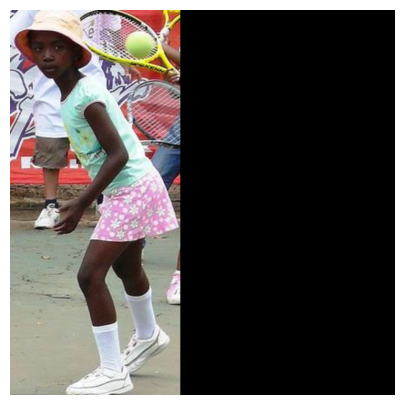

In [21]:
import sys
sys.path.append("../..")
from segment_anything.utils.transforms import ResizeLongestSide
transform = ResizeLongestSide(1024)

def preprocess(x):
    h, w = x.shape[-2:]
    padh = 1024 - h
    padw = 1024 - w
    x = F.pad(x, (0, padw, 0, padh))
    return x

def preprocess_image(image):
    image = transform.apply_image(image)
    H, W, C = image.shape
    image = torch.as_tensor(image)
    image = image.permute(2, 0, 1).contiguous()[None, :, :, :]
    image = preprocess(image)
    return image

prep = preprocess_image(image)
prep = prep[0].permute(1, 2, 0).numpy()
plt.figure(figsize=(5,5))
plt.imshow(prep)
plt.axis('off')
plt.show()

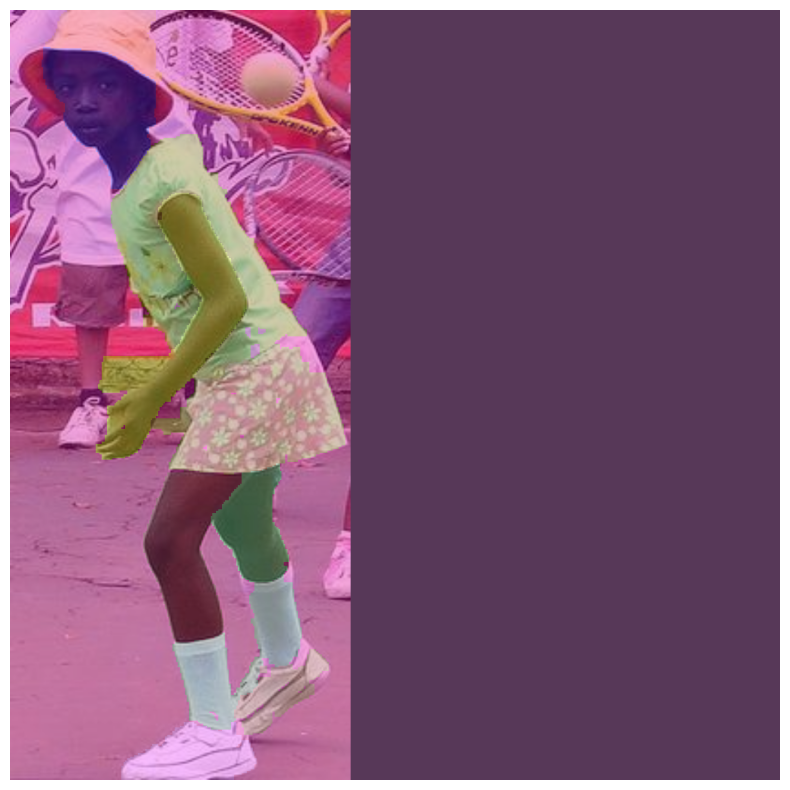

In [23]:
def gt_to_anns(mask_gt):
    labels = np.unique(mask_gt)
    anns = []
    for label in labels:
        mask = np.all(mask_gt == label, axis=-1)
        anns.append({
            'area': np.sum(mask),
            'segmentation': mask,
            'label': label
        })
    return anns

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

label = y[:,:,None]
plt.figure(figsize=(10,10))
plt.imshow(prep)
show_anns(gt_to_anns(label))
plt.axis('off')
plt.show() 

In [25]:
with torch.no_grad():
    model.eval()
    logit = model(torch.as_tensor(x[None,...]).to(device))
logit.shape

torch.Size([1, 20, 1024, 1024])

In [26]:
pred = logit.cpu().numpy().argmax(axis=1)
pred.shape

(1, 1024, 1024)

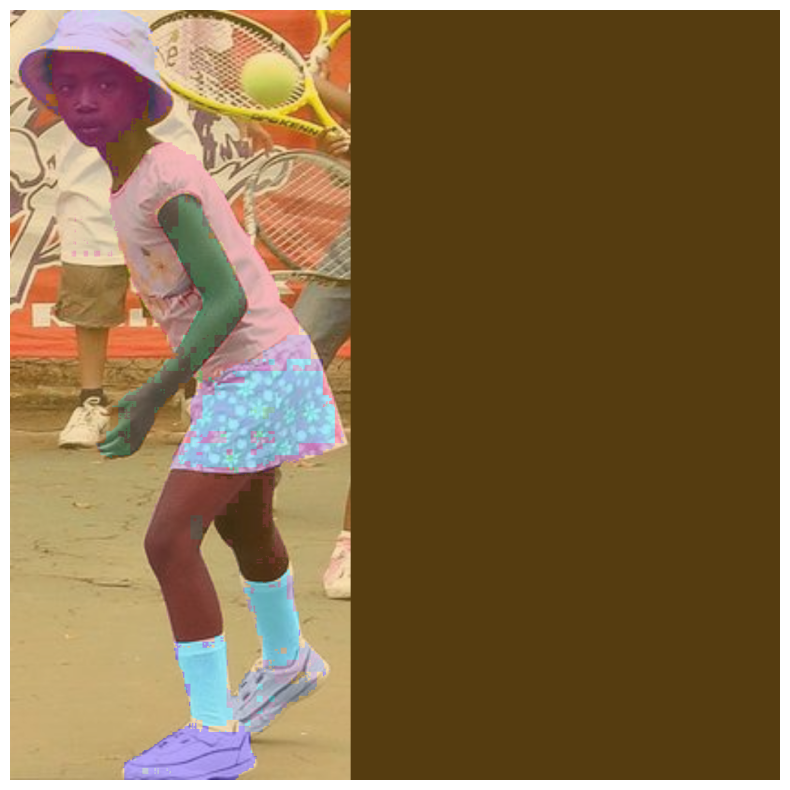

In [27]:
pred = np.transpose(pred, [1, 2, 0])
plt.figure(figsize=(10,10))
plt.imshow(prep)
show_anns(gt_to_anns(pred))
plt.axis('off')
plt.show() 

In [30]:
(pred == label).mean()

0.34235477447509766

In [31]:
import pandas as pd

In [32]:
label_txt = """Background
Hat
Hair
Glove
Sunglasses
UpperClothes
Dress
Coat
Socks
Pants
Jumpsuits
Scarf
Skirt
Face
Left-arm
Right-arm
Left-leg
Right-leg
Left-shoe
Right-shoe"""
label_txt = label_txt.split('\n')
label_txt

['Background',
 'Hat',
 'Hair',
 'Glove',
 'Sunglasses',
 'UpperClothes',
 'Dress',
 'Coat',
 'Socks',
 'Pants',
 'Jumpsuits',
 'Scarf',
 'Skirt',
 'Face',
 'Left-arm',
 'Right-arm',
 'Left-leg',
 'Right-leg',
 'Left-shoe',
 'Right-shoe']

In [33]:
ious = []
pixels = []
for i in range(20):
    label_i = (label == i)
    pred_i = (pred == i)
    ious.append((label_i & pred_i).sum() / ((label_i | pred_i).sum() + 1e-6))
    pixels.append(label_i.sum())
print(np.mean(ious))
pd.DataFrame({ 'labels': label_txt, 'ious': ious, 'pixels': pixels })

0.18114252409888998


,labels,ious,pixels
0,Background,0.318981,292908
1,Hat,0.431651,8425
2,Hair,0.000000,0
3,Glove,0.000000,0
4,Sunglasses,0.000000,0
5,UpperClothes,0.833556,32816
6,Dress,0.017253,28561
7,Coat,0.000000,0
8,Socks,0.733176,14528
9,Pants,0.000000,0
